# Introduction

Goal:
All expectations of typical projects +
clearly describes why the setting is important and what is at stake in the results of the analysis. Even if the reader doesn’t know much about the subject, they know why they care about the results of your analysis.

2020 is an eventful year as the U.S Presidential Election occurs in November. The two candidates, Donald Trump and Joe Biden, have undoubtedly utilized Twitter as an avenue to increase their publicity, connect with supporters, and reach out to potential voters. We were interested in investigating and comparing the similarities and differences between their Twitter activity, both in the context of the election and more broadly, in the past year.

Our revised research question is: how does the Twitter activity of Biden and Trump differ? We will look at how their activities change over time as election nears, as well as behaviors throughout the entire observation period. These investigations would shed light on whether and how certain behaviors or attributes (time of day, length, sentiment) affect popularity, as well as how the candidates' behaviors change as election day nears.

# Data Import and Preparations

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
import nltk
import seaborn as sns
from datetime import date
from string import punctuation
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/sunil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sunil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# can delete this cell 
# def tokenize(phrase):
#     '''
#     Returns the length of an array of individual words in the string phrase
#     phrase: The string to be tokenized
#     '''
#     tokens = phrase.split()
#     return len(tokens)

Sunil/Udai explain here how you guys pulled data from Twitter API.

#### explanation

# Data Cleaning -> move all commented out cells into appendix section. Aren't necessarily important to the reader

#### Importing Biden's data into a dataframe, we print the top-5 rows of each column.

In [34]:
biden = pd.read_csv("biden_tweets.csv")

#### Importing Trump's data into a dataframe, we print the top-5 rows of each column.

In [35]:
trump = pd.read_csv("trump_tweets.csv")

### Main cell that will contain all data cleaning 

In [95]:
# Biden

# biden_word_counts_list = []
# for tweet in biden_tweets["full_text"]:
#     tweet_length = tokenize(tweet)
#     biden_word_counts_list.append(tweet_length)
# biden_tweets["words"] = biden_word_counts_list

# Trump

# trump_word_counts_list = []
# for tweet in trump_tweets["full_text"]:
#     tweet_length = tokenize(tweet)
#     trump_word_counts_list.append(tweet_length)
# trump_tweets["words"] = trump_word_counts_list

# create date time column 
biden["date"] = pd.to_datetime(biden["created_at"], format = "%Y-%m-%d %H:%M:%S")
trump["date"] = pd.to_datetime(trump["created_at"], format = "%Y-%m-%d %H:%M:%S")

# better more efficient way to calculate word count -> produces same results -> will probably delete old method using tokenize
def tweet_length (x):
    return len(x.split())
biden['tweet_length'] = biden['full_text'].map(tweet_length)
trump['tweet_length'] = trump['full_text'].map(tweet_length)

# create time of day column 
# morning = 5 am : 12 pm = any hour value from 5 to 11 
# afternoon = 12 pm : 5 pm = any hour value from 12 to 16 
# evening = 5 pm : 10 pm = any hour value from 17 to 22 
# night = 10 pm : 5 am = any hour value from 23 to 4 (23,0,1,2,3,4) <- wrap around
def time_of_day (x):
    hour = x.hour 
    if  5 <= hour <= 11: 
        return "morning"
    elif 12 <= hour <= 16:
        return "afternoon"
    elif 17 <= hour <= 22:
        return "evening"
    else:
        return "night"

# column for hour of day tweet posted 
def hour(x):
    return x.hour 

# create columns that contain series of night vs day where night = 1 , day = 0 
day_night_map = {"morning":0, "afternoon":0, "evening":1, "night":1}



In [96]:
# cell for applying functions and actually creating the columns 
biden['time_of_day'] = biden['date'].map(time_of_day)
biden['tweet_length'] = biden['full_text'].map(tweet_length)
biden['hour'] = biden['date'].map(hour)
biden['day_or_night'] = biden['time_of_day'].map(day_night_map)

trump['time_of_day'] = trump['date'].map(time_of_day)
trump['tweet_length'] = trump['full_text'].map(tweet_length)
trump['hour'] = biden['date'].map(hour)
trump['day_or_night'] = trump['time_of_day'].map(day_night_map)

#### Converting Tweet dates from string into datetime format prepares for our subsequent analysis. 
#### We obtained Biden and Trump tweets by day from the following source: https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe

In [93]:
print("Before fixing the type, the dates have the type: " + str(type(biden_tweets["created_at"][0])))

# Biden
# biden_tweets["created_at"] = pd.to_datetime(biden_tweets["created_at"], format='%Y-%m-%d %H:%M:%S')
# biden_tweets['date']=biden_tweets['created_at'].dt.date

# # Trump
# # trump_tweets["created_at"] = pd.to_datetime(trump_tweets["created_at"], format='%Y-%m-%d %H:%M:%S')
# trump_tweets['date']=trump_tweets['created_at'].dt.date

biden_tweetsbyday = (biden["date"].dt.date).value_counts().rename_axis('unique_dates').reset_index(name='tweets_each_day')
trump_tweetsbyday= (trump["date"].dt.date).value_counts().rename_axis('unique_dates').reset_index(name='tweets_each_day')

print("After fixing the type, the dates have the type: " + str(type(biden["date"][0])))

Before fixing the type, the dates have the type: <class 'str'>
After fixing the type, the dates have the type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


put everything in this cell ^^^^ in appendix except creation of grouped by day dataframes

In [92]:
# # Check to see if the conversion preserved the date in the order we expect. 
# change instances of "created_at" with "date" and biden_tweets or trump_tweets with biden / trump 

# print("The most recent tweet we have from Biden was tweeted on: " + str(biden_tweets["created_at"][0]))
# print("Biden most recent tweet's year according to Python: " + str(biden_tweets["created_at"][0].year))
# print("Biden most recent tweet's month according to Python: " + str(biden_tweets["created_at"][0].month))
# print("Biden most recent tweet's day according to Python: " + str(biden_tweets["created_at"][0].day))
# print("It appears the conversion was successful")

In [91]:
# # Check to see if we can determine how many days pass between two dates

# print("The most recent tweet we have from Biden was tweeted on: " + str(biden_tweets["created_at"][0]))
# print("The oldest tweet we have from Biden was tweeted on: " + 
#       str(biden_tweets["created_at"][len(biden_tweets["created_at"])-1]))
# test_start = biden_tweets["created_at"][len(biden_tweets["created_at"])-1]
# test_end = biden_tweets["created_at"][0]
# test_start_date = date(test_start.year, test_start.month, test_start.day)
# test_end_date = date(test_end.year, test_end.month, test_end.day)
# delta = test_end_date - test_start_date
# print("Biden's tweets span " + str(delta.days) + " days")
# print("2020 is a leap year with 366 days, so the result above is correct.")

# # Source: https://www.w3resource.com/python-exercises/python-basic-exercise-14.php

Cleaned up to_election computations, ready to be moved to main data cleaning section

In [90]:
# Let's also add a "days_to_election" column to the tweets by day dataframe and regular dataframes 
# this method produces same columns with considerably less code <- easier for reader to understand 
def to_election(x, dates):
    x['days_to_election'] = (date(2020, 11, 3) - dates)
    # convert from day object to int  
    x['days_to_election'] = x['days_to_election'].dt.days

# for biden and trump df 
to_election(biden, biden['date'].dt.date)
to_election(trump, trump['date'].dt.date)
# for biden_tweetsbyday and trump_tweetsbyday df 
to_election(biden_tweetsbyday, biden_tweetsbyday['unique_dates'])
to_election(trump_tweetsbyday, trump_tweetsbyday['unique_dates'])



# Exploratory Data Analysis

#### We first compute summary statistics for the "full_text", "favourite", and "retweet" columns.

In [30]:
# Get summary statistics 

def summ_stat(x, names):
    total_words = 0
    word_counts_list = []

    for tweet in x["full_text"]:
        tweet_length = tokenize(tweet)
        word_counts_list.append(tweet_length)                 
        total_words += tweet_length
    # word count summ stats 
    print(names + " words tweeted: " + "{:.0f}".format(total_words))
    mean_wordcount = np.mean(word_counts_list)
    print("Mean number of words in " + names + " tweets: " + "{:.2f}".format(mean_wordcount))
    median_wordcount = np.median(word_counts_list)
    print("Median number of words in " + names + ": " + "{:.2f}".format(median_wordcount))
    mode_wordcount = statistics.mode(word_counts_list)
    print("Mode number of words in " + names + " tweets: " + "{:.0f}".format(mode_wordcount))
    minimum_words = min(word_counts_list)
    print("The least number of words " + names + " used in a tweet was: " + "{:.0f}".format(minimum_words))
    maximum_words = max(word_counts_list)
    print("The most number of words " + names + " used in a tweet was: " + "{:.0f}".format(maximum_words))
    stddev_wordcount = np.std(word_counts_list)
    print("Standard deviation of number of words in " + names + " tweets: " + "{:.2f}".format(stddev_wordcount))
    
    # favorites stats 
    total_favorites = x["favourite"].sum()
    print(names + " total tweet favorites count: " + "{:.0f}".format(total_favorites))
    mean_favorites = x['favourite'].mean()
    print("Mean number of favorites for " + names + " tweets: " + "{:.2f}".format(mean_favorites))
    median_favorites = x['favourite'].median()
    print("Median number of favorites for " + names + " tweets: " + "{:.2f}".format(median_favorites))
    # mode not useful because of wide range of favourite values 
    minimum_favorites = x['favourite'].min()
    print("The least number of favorites a " + names + " tweet received was: " + "{:.0f}".format(minimum_favorites))
    maximum_favorites = x['favourite'].max()
    print("The most number of favorites a " + names + " tweet received was: " + "{:.0f}".format(maximum_favorites))
    stddev_favorites = x['favourite'].std()
    print("Standard deviation of number of favorites for " + names + " tweets: " + "{:.2f}".format(stddev_favorites))
    
    # retweet stats 
    total_retweets = x["retweets"].sum()
    print(names + " retweets: " + "{:.0f}".format(total_retweets))
    mean_retweets = x['retweets'].mean()
    print("Mean number of retweets for " + names + " tweets: " + "{:.2f}".format(mean_retweets))
    median_retweets = x['retweets'].median()
    print("Median number of retweets for " + names + " tweets: " + "{:.2f}".format(median_retweets))
    minimum_retweets = x['retweets'].min()
    print("The least number of retweets a " + names + " tweet received was: " + "{:.0f}".format(minimum_retweets))
    maximum_retweets = x['retweets'].max()
    print("The most number of retweets a " + names + " tweet received was: " + "{:.0f}".format(maximum_retweets))
    stddev_retweets = x['retweets'].std()
    print("Standard deviation of number of retweets for each " + names + " tweet: " + "{:.2f}".format(stddev_retweets))
    
    # lang stats 
    language_counts = x["language"].value_counts()
    print("Raw number of " + names + " tweets in each language: " + "\n" + str(language_counts))
    # print("Percent of tweets in each language: " + "\n" + str(100 * language_counts / len(x.index))

summ_stat(biden_tweets, 'Biden')
print('\n')
summ_stat(trump_tweets, 'Trump')
# maybe put this in dataframe to make it easier to read / access information 
# NEED TO EXPLAIN WHY CERTAIN TRUMP TWEETS HAVE 0 FAVOURITES 
# perecentage stat in lang stats is redundant 

Biden words tweeted: 100838
Mean number of words in Biden tweets: 32.70
Median number of words in Biden: 35.00
Mode number of words in Biden tweets: 43
The least number of words Biden used in a tweet was: 1
The most number of words Biden used in a tweet was: 59
Standard deviation of number of words in Biden tweets: 12.75
Biden total tweet favorites count: 146530712
Mean number of favorites for Biden tweets: 47513.20
Median number of favorites for Biden tweets: 19678.50
The least number of favorites a Biden tweet received was: 34
The most number of favorites a Biden tweet received was: 1890801
Standard deviation of number of favorites for Biden tweets: 92519.77
Biden retweets: 27712385
Mean number of retweets for Biden tweets: 8985.86
Median number of retweets for Biden tweets: 4409.00
The least number of retweets a Biden tweet received was: 11
The most number of retweets a Biden tweet received was: 327830
Standard deviation of number of retweets for each Biden tweet: 15353.01
Raw numbe

#### Next, we compare histograms plotting Biden and Trump's posts' certain attributes against number of posts in order to see how their Twitter activities differ from one another in length, time, and sentiment, as well as how well-received their activities are.

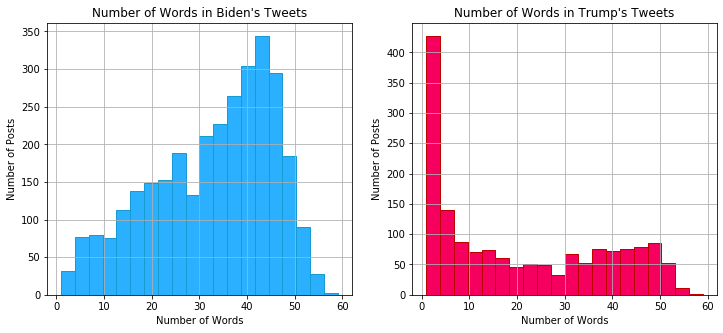

In [121]:
# Number of words

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(biden['tweet_length'], facecolor = '#2ab0ff', edgecolor='#169acf', bins = 20)
ax1.set_title("Number of Words in Biden's Tweets")
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Number of Posts")
ax1.grid(True)

ax2.hist(trump['tweet_length'], facecolor = "#f5005f", edgecolor='#bd0000', bins = 20)
ax2.set_title("Number of Words in Trump's Tweets")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Number of Posts")
ax2.grid(True)

plt.show()

As seen in the side-by-side histograms above comparing the number of words in Biden's and Trump's tweets, Biden's distribution clearly has a higher median with a tail to the left. On the contrary, Trump's distribution exhibits a smaller median with a tail to the right. This signifies that on average, Biden posts longer tweets whereas a majority of Trump's tweets are short (0-5 words had an abnormally high distribution compared to other categories).

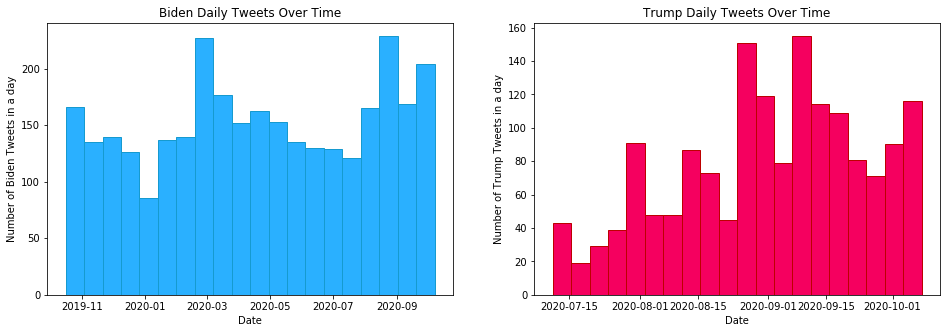

In [125]:
# Tweets per day

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.hist(biden['date'].dt.date, facecolor = '#2ab0ff', edgecolor='#169acf', bins = 20)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Biden Tweets in a day')
ax1.set_title("Biden Daily Tweets Over Time")


ax2.hist(trump['date'].dt.date, facecolor = "#f5005f", edgecolor='#bd0000', bins = 20)
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Trump Tweets in a day')
ax2.set_title("Trump Daily Tweets Over Time")

plt.show()

As seen above, Biden seemed to post roughly the same amount back in November 2019 and September 2020. However, it must be noted that we collected Tweets of Biden throughout a longer period of time since November 2019 whereas we collected Trump's tweets since July 2020 due to the availability of data. This is a potential limitation that will be addressed later on. In order to allow for similar comparisons, we plot Biden and Trump's daily tweets over time from the same period from July to October 2020 below.

# should we do this or no? looking at the section above it seems that biden's will look similar to trump, so i think we could do it. i'm skipping this part for now, it should be just loc(condition: when date is after july 2020).

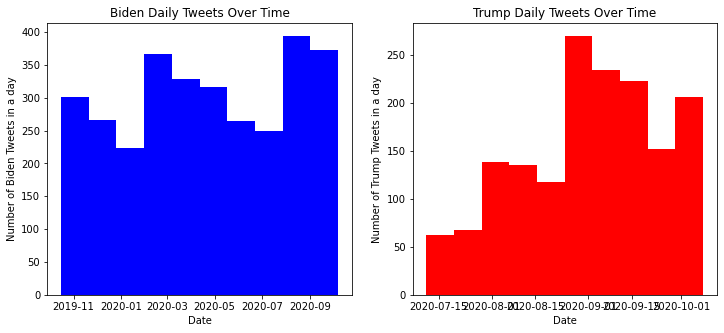

In [100]:
# Tweets per day

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(biden_tweets['date'], color = "blue")
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Biden Tweets in a day')
ax1.set_title("Biden Daily Tweets Over Time")


ax2.hist(trump_tweets['date'], color = "red")
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Trump Tweets in a day')
ax2.set_title("Trump Daily Tweets Over Time")

plt.show()

#### Next, we plot the number of favourites of each candidate against number of posts, obtaining results that are highly concentrated to the left with some upper outliers.

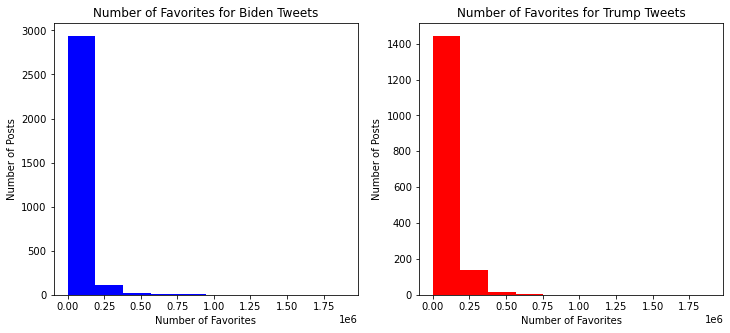

In [46]:
# Favorites <- only show the log scale, doesn't make sense to display this graph 

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1.hist(biden_favorites, color = "blue")
# ax1.set_title("Number of Favorites for Biden Tweets")
# ax1.set_xlabel("Number of Favorites")
# ax1.set_ylabel("Number of Posts")

# ax2.hist(trump_favorites, color = "red")
# ax2.set_title("Number of Favorites for Trump Tweets")
# ax2.set_xlabel("Number of Favorites")
# ax2.set_ylabel("Number of Posts")

# plt.show()

#### To address this and reveal more meaningful relationships between the two variables, we log the number of favourites and plot against number of posts:

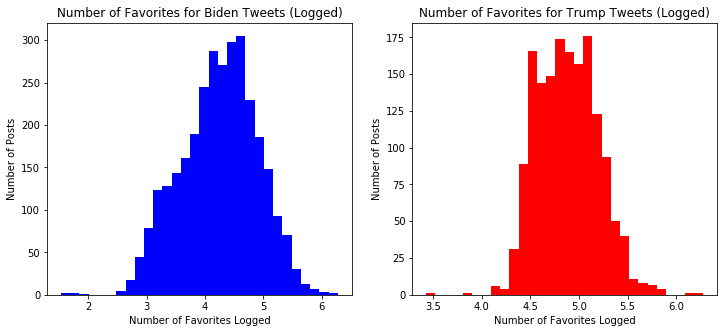

In [148]:
# Favorites logged

# biden_favouritelogged=biden_tweets.copy()
# biden_favouritelogged['favourite']=np.log10(biden_favouritelogged['favourite'])
# biden_favouritelogged=biden_favouritelogged.replace([np.inf, -np.inf], np.nan)
# trump_favouritelogged=trump_tweets.copy()
# trump_favouritelogged['favourite']=np.log10(trump_favouritelogged['favourite'])
# trump_favouritelogged=trump_favouritelogged.replace([np.inf, -np.inf], np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(np.log10(biden["favourite"]), bins = 30, color = "blue")
ax1.set_title("Number of Favorites for Biden Tweets (Logged)")
ax1.set_xlabel("Number of Favorites Logged")
ax1.set_ylabel("Number of Posts")

nozeros = trump[trump['favourite'] > 0]
ax2.hist(np.log10(nozeros['favourite']), bins = 30, color = "red")
ax2.set_title("Number of Favorites for Trump Tweets (Logged)")
ax2.set_xlabel("Number of Favorites Logged")
ax2.set_ylabel("Number of Posts")

plt.show()


## As seen above, this gives a much more meaningful view of the relationship bewteen the two variables. Unfinished__

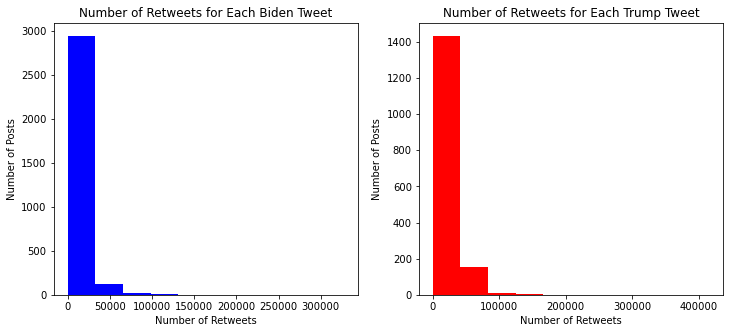

In [44]:
# # Retweets <- only keep log version 

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1.hist(biden_retweets, color="blue")
# ax1.set_title("Number of Retweets for Each Biden Tweet")
# ax1.set_xlabel("Number of Retweets")
# ax1.set_ylabel("Number of Posts")

# ax2.hist(trump_retweets, color="red")
# ax2.set_title("Number of Retweets for Each Trump Tweet")
# ax2.set_xlabel("Number of Retweets")
# ax2.set_ylabel("Number of Posts")

# plt.show()

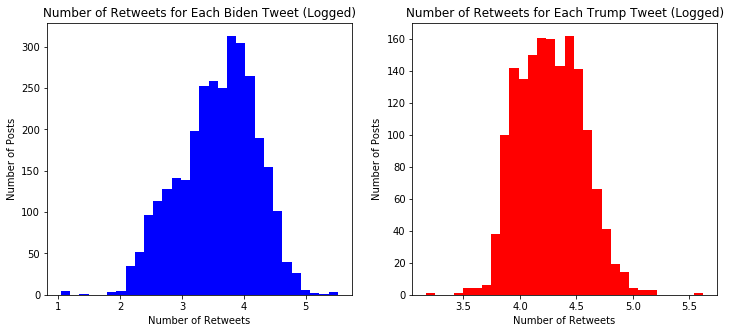

In [151]:
# Retweets logged

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# biden_retweetslogged=biden_tweets.copy()
# biden_retweetslogged['retweets']=np.log10(biden_retweetslogged['retweets'])
# biden_retweetslogged=biden_retweetslogged.replace([np.inf, -np.inf], np.nan)
# trump_retweetslogged=trump_tweets.copy()
# trump_retweetslogged['retweets']=np.log10(trump_retweetslogged['retweets'])
# trump_retweetslogged=trump_retweetslogged.replace([np.inf, -np.inf], np.nan)

ax1.hist(np.log10(biden["retweets"]), bins = 30, color="blue")
ax1.set_title("Number of Retweets for Each Biden Tweet (Logged)")
ax1.set_xlabel("Number of Retweets")
ax1.set_ylabel("Number of Posts")

nozeros = trump[trump['retweets'] > 0]
ax2.hist(np.log10(nozeros["retweets"]), bins = 30, color="red")
ax2.set_title("Number of Retweets for Each Trump Tweet (Logged)")
ax2.set_xlabel("Number of Retweets")
ax2.set_ylabel("Number of Posts")

plt.show()

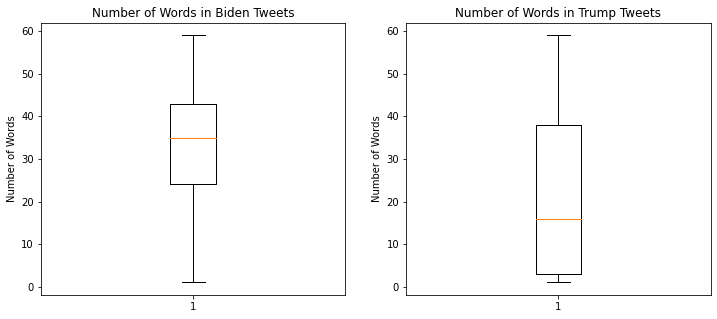

In [50]:
# Number of Words

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.boxplot(biden_word_counts_list)
ax1.set_title("Number of Words in Biden Tweets")
ax1.set_ylabel("Number of Words")

ax2.boxplot(trump_word_counts_list)
ax2.set_title("Number of Words in Trump Tweets")
ax2.set_ylabel("Number of Words")

plt.show()

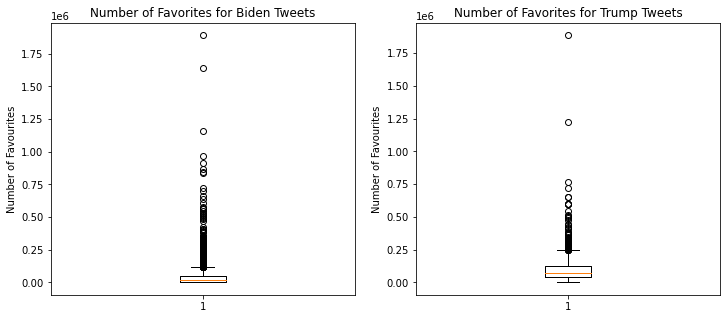

In [52]:
# # Favorites -> delete this -> conveys same information as histograms 

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1.boxplot(biden_favorites)
# ax1.set_title("Number of Favorites for Biden Tweets")
# ax1.set_ylabel("Number of Favourites")

# ax2.boxplot(trump_favorites)
# ax2.set_title("Number of Favorites for Trump Tweets")
# ax2.set_ylabel("Number of Favourites")

# plt.show()

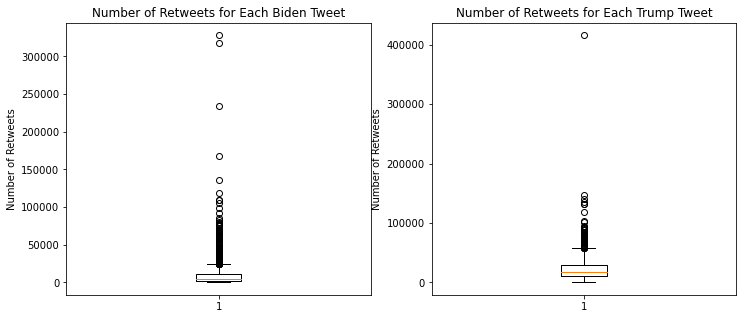

In [53]:
# Retweets -> delete this -> conveys same information as histograms 

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1.boxplot(biden_retweets)
# ax1.set_title("Number of Retweets for Each Biden Tweet")
# ax1.set_ylabel("Number of Retweets")

# ax2.boxplot(trump_retweets)
# ax2.set_title("Number of Retweets for Each Trump Tweet")
# ax2.set_ylabel("Number of Retweets")

# plt.show()

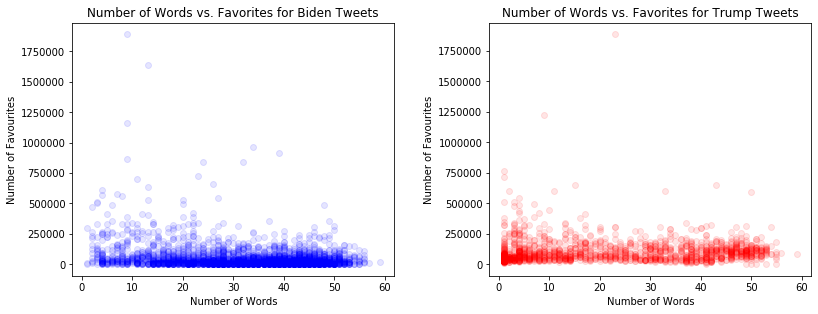

In [162]:
# Number of Words vs. Favorites

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x = "tweet_length", y = "favourite", data= biden, alpha = 0.1, color="blue")
ax1.set_title("Number of Words vs. Favorites for Biden Tweets")
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Number of Favourites")

ax2.scatter(x = 'tweet_length', y = 'favourite', data = trump, alpha = 0.1, color="red")
ax2.set_title("Number of Words vs. Favorites for Trump Tweets")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Number of Favourites")

fig.tight_layout(pad=3.0)
plt.show()

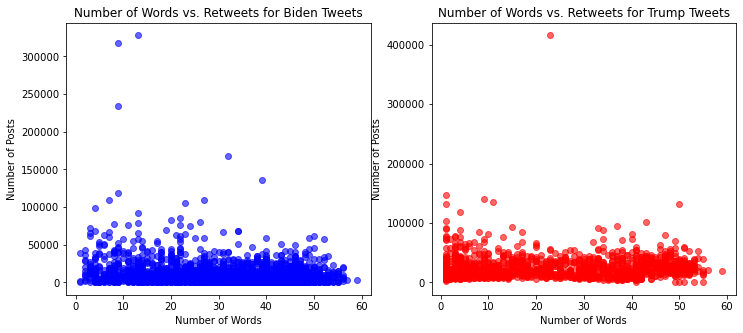

In [66]:
# Number of Words vs. Retweets <- get rid of <- after seeing favourites against number of words we can infer that this graph 
# will not be helpful 

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1.scatter(x = biden_word_counts_list, y = biden_retweets, alpha = 0.6, color="blue")
# ax1.set_title("Number of Words vs. Retweets for Biden Tweets")
# ax1.set_xlabel("Number of Words")
# ax1.set_ylabel("Number of Posts")

# ax2.scatter(x = trump_word_counts_list, y = trump_retweets, alpha = 0.6, color="red")
# ax2.set_title("Number of Words vs. Retweets for Trump Tweets")
# ax2.set_xlabel("Number of Words")
# ax2.set_ylabel("Number of Posts")

# plt.show()

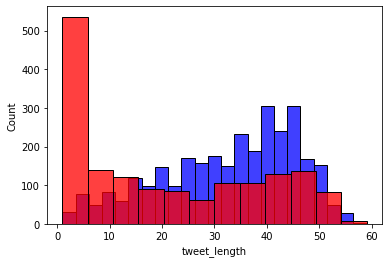

In [172]:
# Number of Favorites vs. Retweets <- only keep log version 

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1.scatter(x = 'favourite', y = 'retweets', data = biden, alpha = 0.1, color="blue")
# ax1.set_title("Number of Favorites vs. Retweets for Biden Tweets")
# ax1.set_xlabel("Number of Favourites")
# ax1.set_ylabel("Number of Words Retweets")

# ax2.scatter(x = 'favourite', y = 'retweets', data = trump, alpha = 0.1, color="red")
# ax2.set_title("Number of Favorites vs. Retweets for Trump Tweets")
# ax2.set_xlabel("Number of Favourites")
# ax2.set_ylabel("Number of Words Retweets")

# fig.tight_layout(pad=3.0)
# plt.show()
# not included in cluster analysis, possibly do an analysis using tweet length 
sns.histplot(x="tweet_length", color = 'blue', data = biden)
sns.histplot(x="tweet_length", color = 'red',data = trump)
plt.show()

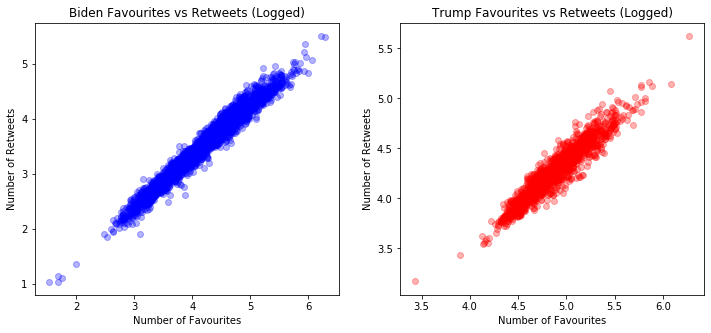

In [170]:
# Logged favorites vs. retweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x = np.log10(biden['favourite']), y = np.log10(biden['retweets']), alpha=0.3, color="blue")
ax1.set_xlabel('Number of Favourites')
ax1.set_ylabel('Number of Retweets')
ax1.set_title('Biden Favourites vs Retweets (Logged)')

fav_filter = trump[trump['favourite'] > 0]
retweet_filter = trump[trump['retweets'] > 0]
ax2.scatter(x = np.log10(fav_filter['favourite']), y = np.log10(retweet_filter['retweets']), alpha=0.3, color="red")
ax2.set_xlabel('Number of Favourites')
ax2.set_ylabel('Number of Retweets')
ax2.set_title('Trump Favourites vs Retweets (Logged)')

plt.show()

# Analysis 2

                            OLS Regression Results                            
Dep. Variable:                  words   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.13
Date:                Sun, 22 Nov 2020   Prob (F-statistic):            0.00147
Time:                        23:26:51   Log-Likelihood:                -12221.
No. Observations:                3084   AIC:                         2.445e+04
Df Residuals:                    3082   BIC:                         2.446e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               31.3277      0.488  

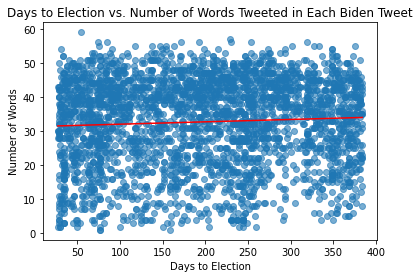

In [46]:
# The updated Trump dataframe looks good as well. Let's begin the analysis, starting with Biden

# Source for t test for linear regression: https://github.com/marcopeix/ISL-linear-regression/blob/master/Linear%20Regression.ipynb

# Biden words vs. days to election

b_days_words_model = linear_model.LinearRegression().fit(biden_tweets[["days_to_election"]], biden_tweets["words"])
b_days_words_predict = b_days_words_model.predict(biden_tweets[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(biden_tweets["days_to_election"], biden_tweets["words"], alpha = 0.6)
ax.plot(biden_tweets["days_to_election"], b_days_words_predict, c = "red")
plt.title("Days to Election vs. Number of Words Tweeted in Each Biden Tweet")
plt.xlabel("Days to Election")
plt.ylabel("Number of Words")

b_days_words_est = sm.OLS(biden_tweets["words"], sm.add_constant(biden_tweets[["days_to_election"]]))
b_days_words_est2 = b_days_words_est.fit()
print(b_days_words_est2.summary())

                            OLS Regression Results                            
Dep. Variable:              favourite   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     458.4
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           6.34e-95
Time:                        23:26:52   Log-Likelihood:                -39428.
No. Observations:                3084   AIC:                         7.886e+04
Df Residuals:                    3082   BIC:                         7.887e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               1.1e+05   3305.443  

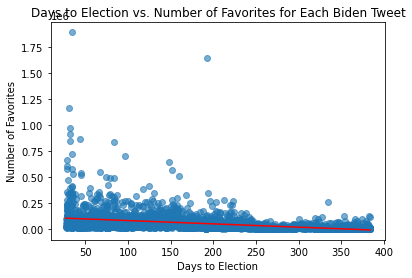

In [47]:
# Biden favorites vs. days to election

b_days_favorites_model = linear_model.LinearRegression().fit(biden_tweets[["days_to_election"]], biden_tweets["favourite"])
b_days_favorites_predict = b_days_favorites_model.predict(biden_tweets[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(biden_tweets["days_to_election"], biden_tweets["favourite"], alpha = 0.6)
ax.plot(biden_tweets["days_to_election"], b_days_favorites_predict, c = "red")
plt.title("Days to Election vs. Number of Favorites for Each Biden Tweet")
plt.xlabel("Days to Election")
plt.ylabel("Number of Favorites")

b_days_favorites_est = sm.OLS(biden_tweets["favourite"], sm.add_constant(biden_tweets[["days_to_election"]]))
b_days_favorites_est2 = b_days_favorites_est.fit()
print(b_days_favorites_est2.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     521.4
Date:                Sun, 22 Nov 2020   Prob (F-statistic):          9.34e-107
Time:                        23:26:52   Log-Likelihood:                -33861.
No. Observations:                3084   AIC:                         6.773e+04
Df Residuals:                    3082   BIC:                         6.774e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.994e+04    543.698  

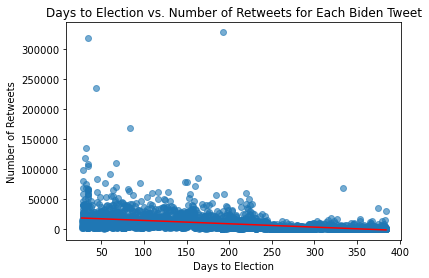

In [48]:
# Biden retweets vs. days to election

b_days_retweets_model = linear_model.LinearRegression().fit(biden_tweets[["days_to_election"]], biden_tweets["retweets"])
b_days_retweets_predict = b_days_retweets_model.predict(biden_tweets[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(biden_tweets["days_to_election"], biden_tweets["retweets"], alpha = 0.6)
ax.plot(biden_tweets["days_to_election"], b_days_retweets_predict, c = "red")
plt.title("Days to Election vs. Number of Retweets for Each Biden Tweet")
plt.xlabel("Days to Election")
plt.ylabel("Number of Retweets")

b_days_retweets_est = sm.OLS(biden_tweets["retweets"], sm.add_constant(biden_tweets[["days_to_election"]]))
b_days_retweets_est2 = b_days_retweets_est.fit()
print(b_days_retweets_est2.summary())

                            OLS Regression Results                            
Dep. Variable:        tweets_each_day   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.322
Date:                Sun, 22 Nov 2020   Prob (F-statistic):            0.00416
Time:                        23:26:53   Log-Likelihood:                -1048.5
No. Observations:                 358   AIC:                             2101.
Df Residuals:                     356   BIC:                             2109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.9903      0.534  

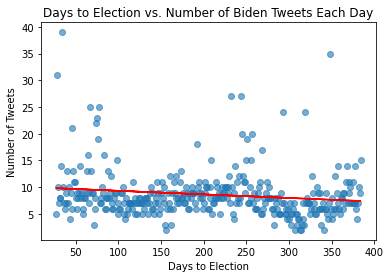

In [49]:
# Biden number of tweets vs. days to election

b_days_tweets_model = linear_model.LinearRegression().fit(biden_tweetsbyday[["days_to_election"]], biden_tweetsbyday["tweets_each_day"])
b_days_tweets_predict = b_days_tweets_model.predict(biden_tweetsbyday[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(biden_tweetsbyday["days_to_election"], biden_tweetsbyday["tweets_each_day"], alpha = 0.6)
ax.plot(biden_tweetsbyday["days_to_election"], b_days_tweets_predict, c = "red")
plt.title("Days to Election vs. Number of Biden Tweets Each Day")
plt.xlabel("Days to Election")
plt.ylabel("Number of Tweets")

b_days_tweets_est = sm.OLS(biden_tweetsbyday["tweets_each_day"], sm.add_constant(biden_tweetsbyday[["days_to_election"]]))
b_days_tweets_est2 = b_days_tweets_est.fit()
print(b_days_tweets_est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  words   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     38.05
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           8.71e-10
Time:                        23:26:53   Log-Likelihood:                -6891.4
No. Observations:                1607   AIC:                         1.379e+04
Df Residuals:                    1605   BIC:                         1.380e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.0292      1.298  

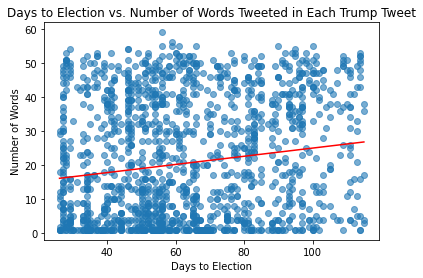

In [50]:
# We will now do the same analysis for Trump's tweets

# Trump words vs. days to election

t_days_words_model = linear_model.LinearRegression().fit(trump_tweets[["days_to_election"]], trump_tweets["words"])
t_days_words_predict = t_days_words_model.predict(trump_tweets[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(trump_tweets["days_to_election"], trump_tweets["words"], alpha = 0.6)
ax.plot(trump_tweets["days_to_election"], t_days_words_predict, c = "red")
plt.title("Days to Election vs. Number of Words Tweeted in Each Trump Tweet")
plt.xlabel("Days to Election")
plt.ylabel("Number of Words")

t_days_words_est = sm.OLS(trump_tweets["words"], sm.add_constant(trump_tweets[["days_to_election"]]))
t_days_words_est2 = t_days_words_est.fit()
print(t_days_words_est2.summary())

                            OLS Regression Results                            
Dep. Variable:              favourite   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02254
Date:                Sun, 22 Nov 2020   Prob (F-statistic):              0.881
Time:                        23:26:53   Log-Likelihood:                -20755.
No. Observations:                1607   AIC:                         4.151e+04
Df Residuals:                    1605   BIC:                         4.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.012e+05   7247.061  

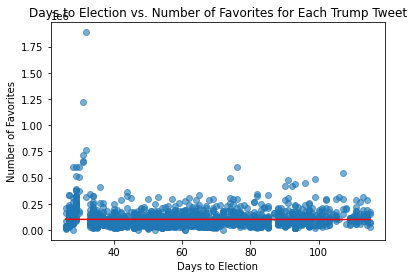

In [51]:
# Trump favorites vs. days to election

t_days_favorites_model = linear_model.LinearRegression().fit(trump_tweets[["days_to_election"]], trump_tweets["favourite"])
t_days_favorites_predict = t_days_favorites_model.predict(trump_tweets[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(trump_tweets["days_to_election"], trump_tweets["favourite"], alpha = 0.6)
ax.plot(trump_tweets["days_to_election"], t_days_favorites_predict, c = "red")
plt.title("Days to Election vs. Number of Favorites for Each Trump Tweet")
plt.xlabel("Days to Election")
plt.ylabel("Number of Favorites")

t_days_favorites_est = sm.OLS(trump_tweets["favourite"], sm.add_constant(trump_tweets[["days_to_election"]]))
t_days_favorites_est2 = t_days_favorites_est.fit()
print(t_days_favorites_est2.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.007887
Date:                Sun, 22 Nov 2020   Prob (F-statistic):              0.929
Time:                        23:26:54   Log-Likelihood:                -18139.
No. Observations:                1607   AIC:                         3.628e+04
Df Residuals:                    1605   BIC:                         3.629e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.319e+04   1422.648  

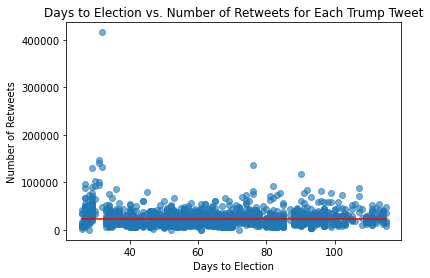

In [52]:
# Trump retweets vs. days to election

t_days_retweets_model = linear_model.LinearRegression().fit(trump_tweets[["days_to_election"]], trump_tweets["retweets"])
t_days_retweets_predict = t_days_retweets_model.predict(trump_tweets[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(trump_tweets["days_to_election"], trump_tweets["retweets"], alpha = 0.6)
ax.plot(trump_tweets["days_to_election"], t_days_retweets_predict, c = "red")
plt.title("Days to Election vs. Number of Retweets for Each Trump Tweet")
plt.xlabel("Days to Election")
plt.ylabel("Number of Retweets")

t_days_retweets_est = sm.OLS(trump_tweets["retweets"], sm.add_constant(trump_tweets[["days_to_election"]]))
t_days_retweets_est2 = t_days_retweets_est.fit()
print(t_days_retweets_est2.summary())

                            OLS Regression Results                            
Dep. Variable:        tweets_each_day   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     20.04
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           2.28e-05
Time:                        23:26:54   Log-Likelihood:                -337.35
No. Observations:                  89   AIC:                             678.7
Df Residuals:                      87   BIC:                             683.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               31.9269      3.304  

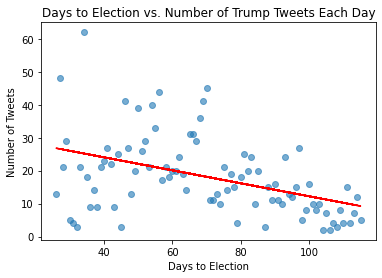

In [53]:
# Trump number of tweets vs. days to election

t_days_tweets_model = linear_model.LinearRegression().fit(trump_tweetsbyday[["days_to_election"]], trump_tweetsbyday["tweets_each_day"])
t_days_tweets_predict = t_days_tweets_model.predict(trump_tweetsbyday[["days_to_election"]])
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(trump_tweetsbyday["days_to_election"], trump_tweetsbyday["tweets_each_day"], alpha = 0.6)
ax.plot(trump_tweetsbyday["days_to_election"], t_days_tweets_predict, c = "red")
plt.title("Days to Election vs. Number of Trump Tweets Each Day")
plt.xlabel("Days to Election")
plt.ylabel("Number of Tweets")

t_days_tweets_est = sm.OLS(trump_tweetsbyday["tweets_each_day"], sm.add_constant(trump_tweetsbyday[["days_to_election"]]))
t_days_tweets_est2 = t_days_tweets_est.fit()
print(t_days_tweets_est2.summary())

# Optional Analysis

In [76]:
from collections import Counter 
from string import punctuation
  
allbidenwords = ""

#concatenate texts in all of biden's post into one string, making them all lowercase
for i in range(len(biden_tweets)):
    allbidenwords+=biden_tweets['full_text'][i].lower()

#transforms the concatenated string into a list of all the words in the string
allbidenwords2 = allbidenwords.split()

#download the nltk packages – action required running this code: go to Corpora, and download "stopwords"
import nltk

from nltk.corpus import stopwords

#obtain the english stopwords

stopwords = stopwords.words('english')

#create and add our own list of english stopwords

additionalstopwords=['',"—","-","need","get","make","every","one","us","take","it’s","it.","we're","i'll","i'm","let","can't","going","would"]

for i in range(len(additionalstopwords)):
    stopwords.append(additionalstopwords[i])
    
#remove all leading and trailing punctuations of biden's words
for i in range(len(allbidenwords2)):
    allbidenwords2[i]=allbidenwords2[i].strip(punctuation)
    
#create a new counter object which we will use to count the words and their frequencies

Counter = Counter(allbidenwords2) 

#returns the top-200 (leave a large enough margin) most freqeunt words and their count
bidenmostfrequentwords = Counter.most_common(200)

#filter out the english stopwords from the list of words

bidenmostfrequentwords = [(word, count) for word, count in bidenmostfrequentwords if word not in stopwords]
  
#print only the top-30 most frequent words and their count
print(bidenmostfrequentwords[:30]) 


[('trump', 796), ('president', 737), ('donald', 499), ('nation', 346), ('american', 335), ('country', 306), ('people', 289), ('day', 271), ('time', 241), ('crisis', 220), ('care', 214), ('health', 212), ('help', 211), ('together', 207), ('today', 206), ('america', 197), ('americans', 183), ('work', 176), ('years', 175), ('white', 170), ('back', 168), ('know', 157), ('campaign', 151), ('better', 148), ('house', 143), ('covid-19', 142), ('world', 137), ('like', 137), ('must', 134), ('never', 132)]


In [77]:
from collections import Counter 
from string import punctuation

alltrumpwords = ""

#concatenate texts in all of trump's post into one string, making them all lowercase
for i in range(len(trump_tweets)):
    alltrumpwords+=trump_tweets['full_text'][i].lower()

#transforms the concatenated string into a list of all the words in the string
alltrumpwords2 = alltrumpwords.split()

#download the nltk packages – action required running this code: go to Corpora, and download "stopwords"
import nltk

#nltk.download() <--unhighlight this code to do the installation

from nltk.corpus import stopwords

#obtain the english stopwords

stopwords = stopwords.words('english')

#create and add our own list of english stopwords

additionalstopwords=['',"—","-","need","get","make","every","one","us","take","it’s","it.","we're","i'll","i'm","let","can't","going","would"]

for i in range(len(additionalstopwords)):
    stopwords.append(additionalstopwords[i])
    
#remove all leading and trailing punctuations of trump's words
for i in range(len(alltrumpwords2)):
    alltrumpwords2[i]=alltrumpwords2[i].strip(punctuation)
    
#create a new counter object which we will use to count the words and their frequencies

Counter = Counter(alltrumpwords2) 

#returns the top-200 (leave a large enough margin) most freqeunt words and their count
trumpmostfrequentwords = Counter.most_common(200)

#filter out the english stopwords from the list of words

trumpmostfrequentwords = [(word, count) for word, count in trumpmostfrequentwords if word not in stopwords]
  
#print only the top-30 most frequent words and their count
print(trumpmostfrequentwords[:30])

[('great', 200), ('amp', 194), ('biden', 131), ('people', 120), ('joe', 99), ('news', 94), ('fake', 88), ('never', 84), ('vote', 78), ('country', 74), ('big', 73), ('even', 71), ('total', 70), ('democrats', 69), ('president', 69), ('many', 65), ('left', 64), ('like', 61), ('new', 61), ('want', 60), ('back', 60), ('complete', 59), ('maga', 58), ('endorsement', 58), ('thank', 57), ('years', 56), ('state', 56), ('election', 56), ('win', 53), ('radical', 53)]


Next, we sentiment code the top 30 words from each candidates into three categories: positive, neutral, and negative.

In [78]:
print("Biden's top-30 most frequent words are:\n")
print(bidenmostfrequentwords[:30])
print("\nTrump's top-30 most frequent words are:\n")
print(trumpmostfrequentwords[:30])

Biden's top-30 most frequent words are:

[('trump', 796), ('president', 737), ('donald', 499), ('nation', 346), ('american', 335), ('country', 306), ('people', 289), ('day', 271), ('time', 241), ('crisis', 220), ('care', 214), ('health', 212), ('help', 211), ('together', 207), ('today', 206), ('america', 197), ('americans', 183), ('work', 176), ('years', 175), ('white', 170), ('back', 168), ('know', 157), ('campaign', 151), ('better', 148), ('house', 143), ('covid-19', 142), ('world', 137), ('like', 137), ('must', 134), ('never', 132)]

Trump's top-30 most frequent words are:

[('great', 200), ('amp', 194), ('biden', 131), ('people', 120), ('joe', 99), ('news', 94), ('fake', 88), ('never', 84), ('vote', 78), ('country', 74), ('big', 73), ('even', 71), ('total', 70), ('democrats', 69), ('president', 69), ('many', 65), ('left', 64), ('like', 61), ('new', 61), ('want', 60), ('back', 60), ('complete', 59), ('maga', 58), ('endorsement', 58), ('thank', 57), ('years', 56), ('state', 56), ('el

In [79]:
bidenpositive=["nation","american","country","people","care","health","help","together","america","americans","better","like"]
bidenneutral=["trump","president","donald","day","time","today","work","years","white","back","know","campaign","house","covid-19","world","must"]
bidennegative=["crisis","never"]

print(len(bidenpositive))
print(len(bidenneutral))
print(len(bidennegative))

12
16
2


In [80]:
trumppositive=["great","people","vote","country","big","many","like","new","want","complete","maga","endorsement","thank","win"]
trumpneutral=["amp","biden","joe","news","even","total","democrats","president","left","back","years","state","election"]
trumpnegative=["fake","never","radical"]

print(len(trumppositive))
print(len(trumpneutral))
print(len(trumpnegative))

14
13
3


As shown above, 12 out of the top-30 most frequently used words by Biden are positive, 16 are neutral, and 2 are negative. On the other hand, 14 out of the top-30 most frequently used words by trump are positive, 13 are neutral, and 3 are negative. This mirrors our results of sentiment analysis, which found that Trump had a lot more positive tweets than Biden (as seen through 14 > 12) as well as more negative tweets than Biden (as seen through 3 > 2). This adds further credibility to our findings that Trump's results seem more polarized and subjective than Biden's, as demonstrated in the polarity vs subjectivity plots.

# Cluster Analysis by Time of Day 

### Exploring the time of day clusters

Biden: 
evening      1343
night        1196
afternoon     518
morning        27
Name: time_of_day, dtype: int64


Trump: 
night        555
evening      476
afternoon    409
morning      167
Name: time_of_day, dtype: int64


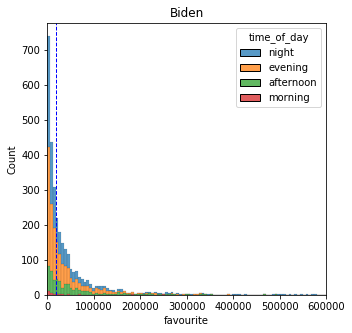

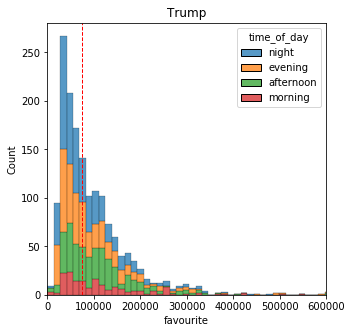

In [184]:
# show number of tweets at certain times. I found it suprising the large amount of tweets during the night 
print("Biden: ")
print(biden.time_of_day.value_counts()) 
print('\n')
print("Trump: ")
print(trump.time_of_day.value_counts())

# blue dashed line = biden median value for favorites recieved 
# red dashed line = trump median value for favorites recieved 
plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = biden)
plt.xlim(left = 0, right = 600000)
plt.title("Biden")
plt.axvline(biden['favourite'].median(), color='blue', linestyle='dashed', linewidth=1)

plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = trump)
plt.xlim(left = 0, right = 600000)
plt.title("Trump")
plt.axvline(trump['favourite'].median(), color='red', linestyle='dashed', linewidth=1)


plt.show()


### Tweet Length vs Number of Favorites

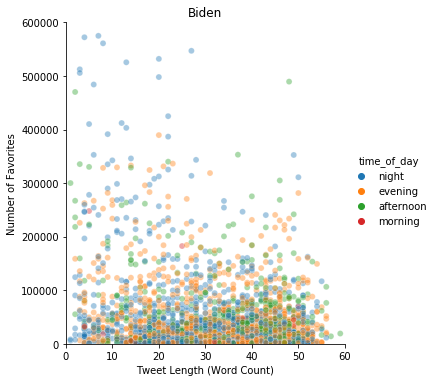

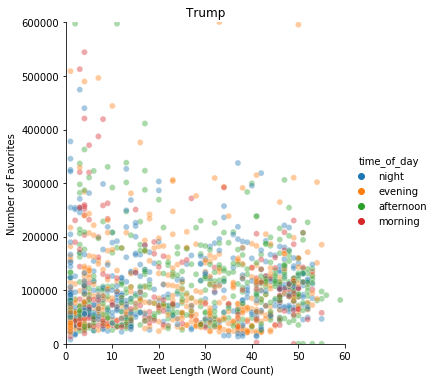

In [185]:
# does not seem to be a relationship between tweet length and number of favorites recieved 
# trump has many tweets that are a single hyperlink to another tweet, which is why he has many tweets of length = 1
sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = biden)
plt.xlabel("Tweet Length (Word Count)")
plt.ylabel("Number of Favorites")
plt.title("Biden")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)

sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = trump)
plt.xlabel("Tweet Length (Word Count)")
plt.ylabel("Number of Favorites")
plt.title("Trump")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)
plt.show()

### Research Question: Does the time of day impact tweet behavior? 
#### null hypothesis : time of day does not impact amount of favorites recieved by a tweet <- check for both trump and biden

Biden p value: 4.602892091368418e-168
Trump p vale: 9.077655265894341e-294


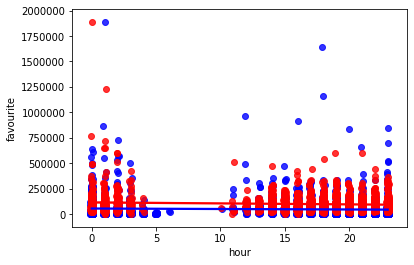

In [176]:
print("Biden p value: {}".format(ttest_ind(biden['favourite'], biden['hour'])[1]))
print("Trump p vale: {}".format(ttest_ind(trump['favourite'], trump['hour'])[1]))
sns.regplot(x='hour', y = 'favourite', color = 'blue',x_jitter = 0.1, data = biden)
sns.regplot(x='hour', y = 'favourite', color = 'red', x_jitter = 0.1, data = trump)
plt.show()

Both t-tests indicate that the null hypothesis should be rejected, and that there is a significant difference in 
the amount of likes recieved during the day (morning and afternoon) versus during the night (evening and night). However, the extremely small p value might not be a strong predictor of the relationship because of the large sample size. The slope in the graph shown above is a horizontal line (~0), which suggests that there is not a linear relationship between time of day (hour) and favorites recieved. 

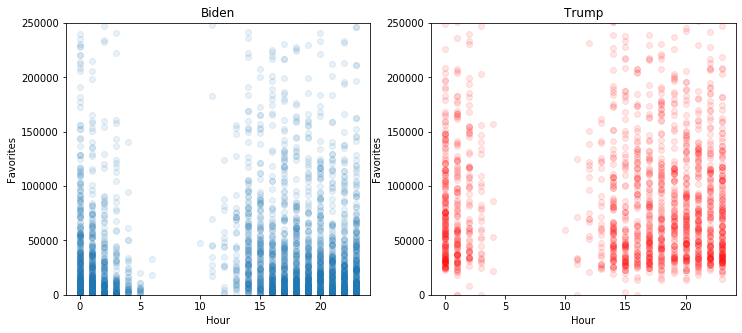

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(biden['hour'],biden['favourite'], alpha = 0.1)
ax1.set_title("Biden")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Favorites")
ax1.set_ylim(top =250000, bottom = 0)

ax2.scatter(trump['hour'],trump['favourite'], color = 'red', alpha = 0.1)
ax2.set_title("Trump")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Favorites")
ax2.set_ylim(top = 250000, bottom = 0)
plt.show()

## Logistic Regression
A heavily liked (favorited) tweet is one that recieves more than 50000 favorites, otherwise it is not heavily liked.

In [179]:
def liked(x):
    if x > 50000:
        return 1 
    else:
        return 0 
biden['loved'] = biden['favourite'].map(liked)
trump['loved'] = trump['favourite'].map(liked)

def logit(x):
    return np.exp(x) / (np.exp(x) + 1)

def log_reg(biden, trump):
    x = 0
    subplot = [121, 122]
    title = ['Biden', 'Trump']
    color = ['blue', 'red']
    df = [biden, trump]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax = [ax1, ax2]
    for i in df: 
        model = LogisticRegression(solver = "lbfgs").fit(i[['hour']], i['loved'])
        x_values = np.linspace(0, 23, 100) 
        ax[x].scatter(i['hour'], i['loved'] + np.random.normal(0, 0.05, size=len(i)), alpha = 0.1, color = color[x])
        ax[x].plot(x_values, logit(x_values * model.coef_[0,0] + model.intercept_[0]), color = color[x])
        ax[x].set_title(title[x])
        ax[x].set_xlabel("hour")
        ax[x].set_ylabel("probability of loved tweet")
        
        x +=1

All data included


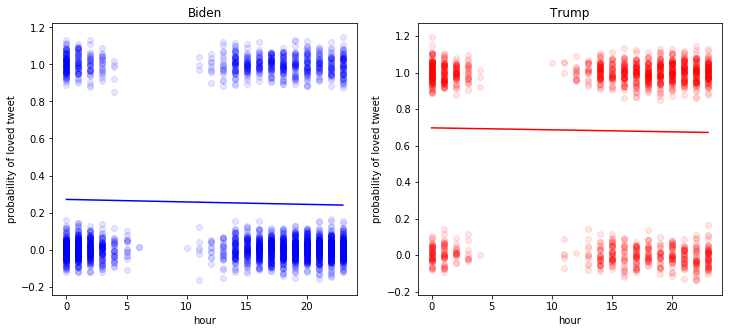

In [180]:
print("All data included")
log_reg(biden, trump)

I am deciding to exclude the tweets that recieved more than 200,000 likes in both data sets because these values can greatly skew significance values and regression models. This means that 4.44% of biden data set is not included and 8.96% of trump data set is not included in the analysis.

In [182]:
print("Number of Biden tweets recieving more than 200,000 favourites: {}".format(len(biden[biden['favourite'] > 200000])))
print("Number of Trump tweets recieving more than 200,000 favourites: {}".format(len(trump[trump['favourite'] > 200000])))

Number of Biden tweets recieving more than 200,000 favourites: 137
Number of Trump tweets recieving more than 200,000 favourites: 144


After filtering out tweets with more than 200000 favorites


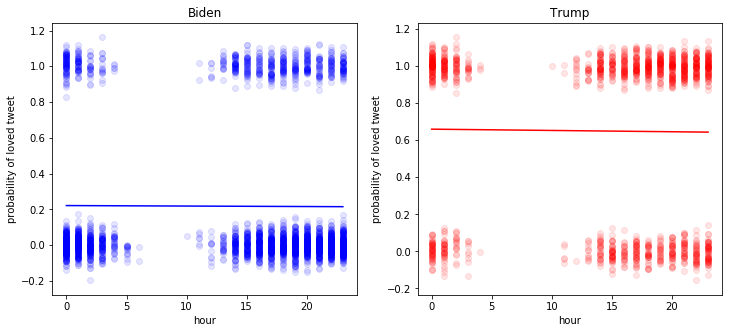

In [181]:
biden_filtered = biden[biden['favourite'] < 200000]
trump_filtered = trump[trump['favourite']< 200000]

print("After filtering out tweets with more than 200000 favorites")
log_reg(biden_filtered, trump_filtered)

From the logistic regression, there does not seem to be a strong correlation between the time a tweet is posted (hour of the day) and the probability of recieving more than 100,000 favorites for that tweet for either Trump or Biden. Additionally, filtering outliers does not seem to impact the results.

### Question for Reviewers
* Would normalization help in any part of this analysis?
* How to fit a binomal regression / fit? I think this could benefit the analysis for time of day vs probability of loved tweet